# Методы индустрии для анализа CTR

Итак, мы с вами узнали, что для анализа CTR t-тест не подходит, а заменять его на средний пользовательский CTR - плохая идея. И что в таком случае делать?

К счастью, в "большой" аналитике проблема уже решена, и есть несколько подходов к этому вопросу. Рассмотрим три из них.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from tqdm.auto import tqdm
from joblib import Parallel, delayed

rng = np.random.default_rng()

In [2]:
def generate_ctr_agg(rng, n=1000, total_posts=50, a_views=10, b_views=10, a_likes=5, b_likes=20, multiplier=1.0):

    #генерируем вероятности просмотров
    p_views=rng.beta(a=a_views, b=b_views, size=n)
    #генерируем вероятности лайков (и делаем мультипликативный сдвиг)
    p_likes=rng.beta(a=a_likes, b=b_likes, size=n) * multiplier

    #генерируем количество просмотренных постов каждым пользователем
    views = rng.binomial(n=total_posts, p=p_views, size=n)
    #генерируем количество поставленных лайков каждым пользователем
    likes = rng.binomial(n=views, p=p_likes, size=n)

    #возвращаем датафрейм
    return(pd.DataFrame({"user":np.arange(0, n, 1), "views":views, "likes":likes}))

Сгенерируем контрольную и тестовую выборку заранее - чтобы можно было наглядно смотреть на результаты тестов. Пользовательский CTR считать не будем, нам он не нужен.

In [3]:
control = generate_ctr_agg(rng=np.random.default_rng(2112))
test = generate_ctr_agg(rng=np.random.default_rng(2113), multiplier=1.1)

In [4]:
control

,user,views,likes
0,0,30,4
1,1,34,4
2,2,19,4
3,3,19,8
4,4,21,3
...,...,...,...
995,995,25,0
996,996,27,9
997,997,20,4
998,998,16,3


In [5]:
test

,user,views,likes
0,0,27,10
1,1,33,11
2,2,31,4
3,3,25,5
4,4,25,9
...,...,...,...
995,995,27,6
996,996,26,4
997,997,27,2
998,998,21,0


## Пуассон-бутстрап

Вот мы и снова встретились! В этот раз бутстрап действительно будет более удачным вариантом, чем t-тест - ввиду того, что оценивает дисперсию он не по готовой формуле, а эмпирически через симуляции. В результате её оценка гораздо точнее, и бутстрап будет адекватно контролировать ошибку I рода. Предположительно.

Давайте напишем под это кастомную функцию:

In [6]:
def classic_bootstrap(a, b, n_iter=10000, perc=[2.5, 97.5]):

    rng = np.random.default_rng() #генератор случайных чисел

    ctrs = [] #сюда будем складывать разницу в CTR

    for _ in range(n_iter):
        #берём подвыборки с возвращением для каждой группы
        a_boot = a.sample(frac=1, replace=True)
        b_boot = b.sample(frac=1, replace=True)

        #считаем CTR на каждой из выборок
        ctr_a = a_boot.likes.sum() / a_boot.views.sum()
        ctr_b = b_boot.likes.sum() / b_boot.views.sum()

        #сохраняем разницу
        ctrs.append(ctr_a - ctr_b)
    
    #возвращаем перцентильный доверительный интервал
    return(np.percentile(ctrs, perc))

Оценим доверительный интервал для разницы в CTR:

In [7]:
classic_bootstrap(control, test)

array([-0.02607744, -0.00527644])

Результат получился! Но тут вы можете задать мне вопрос: разве я не зарёкся работать с бутстрапом из-за его скорости? Может, есть что-то более эффективное? И оно действительно есть - однако мне в этот раз хочется наглядно показать, что бутстрап действительно справляется там, где не справился t-тест. К тому же нас сейчас ждёт не совсем обычный бутстрап; я покажу вам **Пуассоновский бутстрап**.

Чтобы понять его суть, нам нужно ещё раз взглянуть на главную механику бутстрапа - *взятие подвыборки с возвращением*. На каждой его итерации мы берём изначальную выборку, после чего берём из неё подвыборку такого же размера. Однако она не идентична оригиналу; из-за того, что мы берём наблюдения с возвращением, одно и то же наблюдение может быть взято больше одного раза - а какие-то могут быть не взяты вообще.

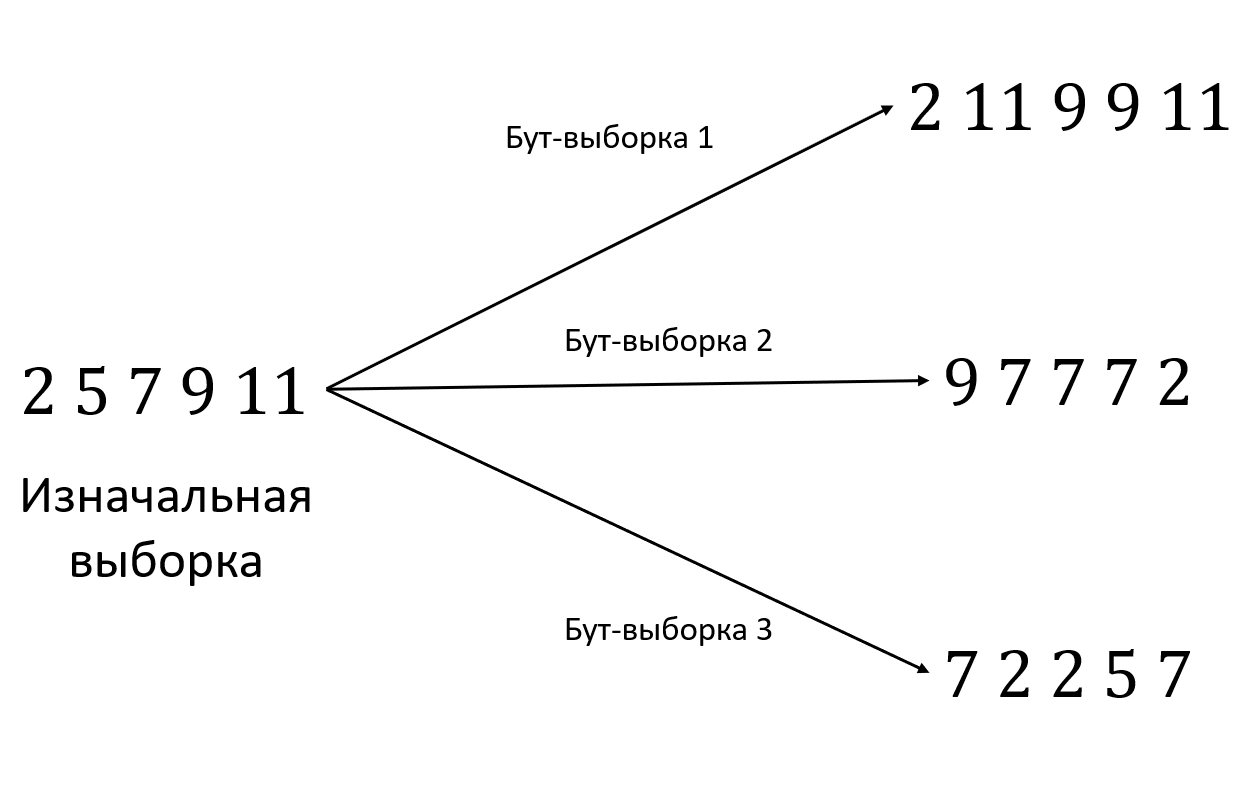

А теперь время небольшого переосмысления; вместо того, чтобы писать значения взятых наблюдений, мы можем просто написать количество раз, сколько мы берём каждое наблюдение, и умножить на них изначальную выборку:

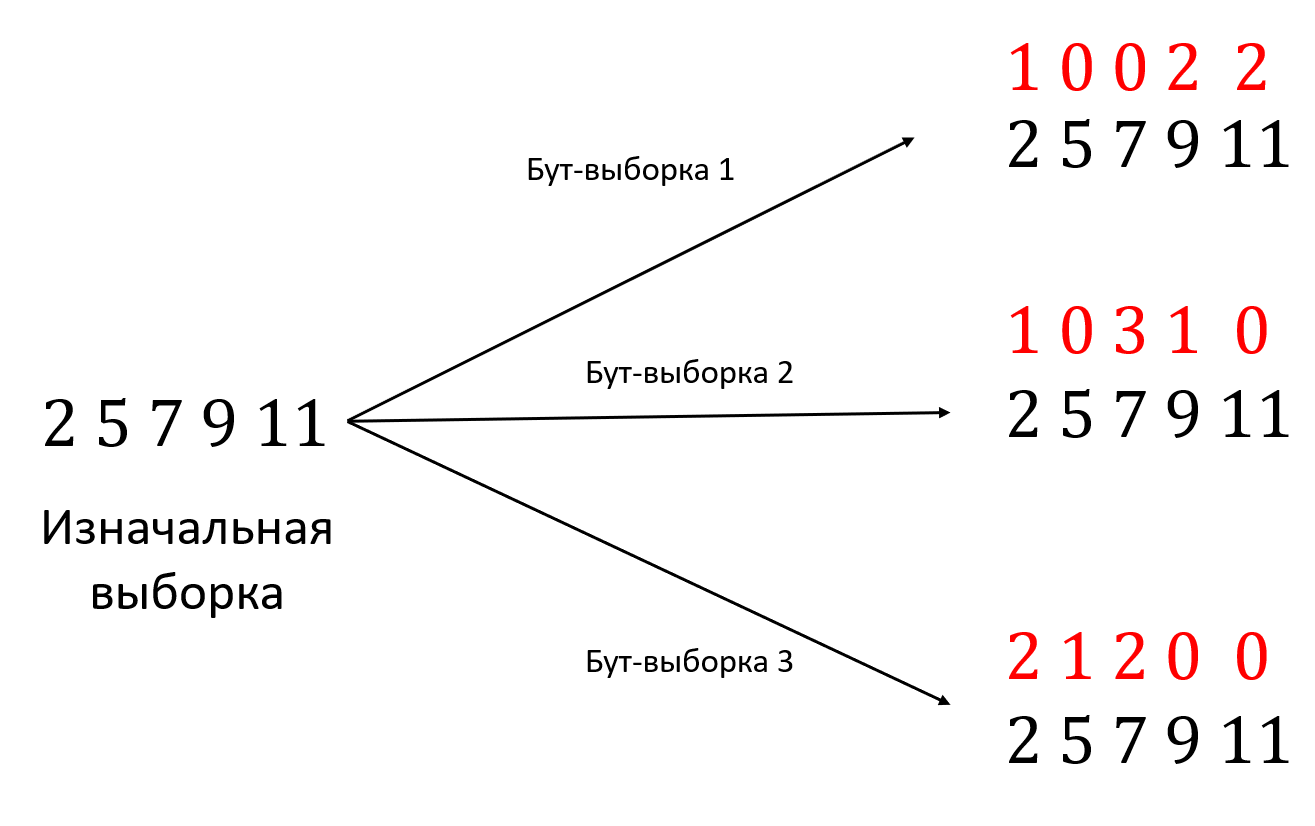

Давайте убедимся, что это одно и то же, на примере первой бут-выборки:

In [8]:
print(f"Сумма значений в бут-выборке (первый способ): {sum([2, 11, 9, 9, 11])}")
print(f"Сумма значений в бут-выборке (второй способ): {sum([2*1, 5*0, 7*0, 9*2, 11*2])}")

Сумма значений в бут-выборке (первый способ): 42
Сумма значений в бут-выборке (второй способ): 42


Результат идентичен! Значит, вместо того, чтобы использовать [choice()](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) или [.sample()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) для взятия подвыборок, мы можем генерировать целые числа из какого-то распределения и умножать на них значения выборки. 

А какое распределение у нас так умеет? Конечно же, **биномиальное**! А чтобы не полагаться на размер выборки (биномиальному нужен параметр n), воспользуемся его близким родственником - **распределением Пуассона** с параметром $\lambda$, равным одному:

<Axes: ylabel='Count'>

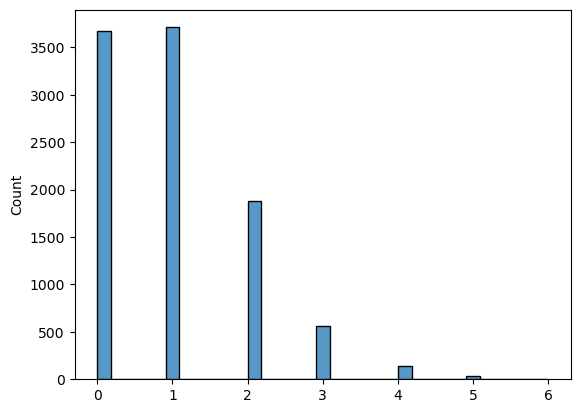

In [9]:
sns.histplot(rng.poisson(lam=1.0, size=10000))

Можем видеть по форме распределения, что чаще всего будут выдаваться числа 0 и 1 (невзятие числа и взятие 1 раз), остальные количества будут встречаться реже, но с ненулевой вероятностью.

Более того, с использованием `numpy` мы можем полностью обойти необходимость писать цикл! Вся магия - в аргументе `size`, которым задаётся размер выборки; вместо указания одного числа мы можем дать кортеж с несколькими числами. Так, если дать ему на вход числа $(m, n)$, то мы получим на выходе матрицу размерности $m \times n$, заполненную значениями из распределения Пуассона. И если $m$ - это число итераций бутстрапа, а $n$ - размер выборки, то мы в один заход генерируем все нужные нам показатели!

Например, вот так мы можем сгенерировать 10 итераций бутстрапа для выборки в 5 наблюдений:

In [12]:
weight_matrix = rng.poisson(lam=1.0, size=(10, 5))
weight_matrix

array([[2, 0, 1, 1, 1],
       [2, 1, 2, 1, 0],
       [3, 1, 0, 2, 0],
       [2, 1, 3, 1, 0],
       [0, 1, 1, 1, 2],
       [2, 1, 3, 0, 1],
       [3, 2, 1, 4, 1],
       [0, 0, 1, 0, 0],
       [1, 2, 0, 0, 0],
       [0, 1, 0, 0, 2]], dtype=int64)

Домножаем это на вектор значений выборки - и получаем матрицу, состоящую из 10 бут-выборок:

In [14]:
boot_samples = np.array([2, 5, 7, 9, 11]) * weight_matrix
boot_samples

array([[ 4,  0,  7,  9, 11],
       [ 4,  5, 14,  9,  0],
       [ 6,  5,  0, 18,  0],
       [ 4,  5, 21,  9,  0],
       [ 0,  5,  7,  9, 22],
       [ 4,  5, 21,  0, 11],
       [ 6, 10,  7, 36, 11],
       [ 0,  0,  7,  0,  0],
       [ 2, 10,  0,  0,  0],
       [ 0,  5,  0,  0, 22]], dtype=int64)

Остаётся применить какую-нибудь функцию по рядам - и у нас готово распределение интересующего нас показателя! Например, суммы:

In [15]:
boot_samples.sum(axis=1) #axis=1 означает суммирование по рядам

array([31, 32, 29, 39, 43, 41, 70,  7, 12, 27], dtype=int64)

Вот вам и весь Пуассон-бутстрап - додумались до такой штуки в Google, можете почитать их [небольшой блогпост](https://www.unofficialgoogledatascience.com/2015/08/an-introduction-to-poisson-bootstrap26.html) на тему.

Напишем функцию, которая его реализует:

In [16]:
def poisson_bootstrap(a, b, n_iter=10000, perc=[2.5, 97.5]):

    rng = np.random.default_rng() #генератор случайных чисел

    #генерируем веса
    a_weights = rng.poisson(lam=1.0, size=(n_iter, a.shape[0]))
    b_weights = rng.poisson(lam=1.0, size=(n_iter, b.shape[0]))

    #считаем 
    ctr_a = (a.likes.values * a_weights).sum(axis=1)/ (a.views.values * a_weights).sum(axis=1)
    ctr_b = (b.likes.values * b_weights).sum(axis=1)/ (b.views.values * b_weights).sum(axis=1)

    #возвращаем доверительный интервал для разницы
    return(np.percentile(ctr_a - ctr_b, perc))

Считаем доверительный интевал для разности в CTR:

In [17]:
poisson_bootstrap(control, test)

array([-0.02605069, -0.00510988])

Результат очень похож на то, что получилось выше! А значит, процесс реально сопоставим с оригиналом.

**Это всё, конечно, интересно** - скажете вы. **А зачем мы это делали? Не проще ли было просто брать подвыборки с повторением по классике?** 

Давайте замерим среднее время выполнения обеих функций:

In [18]:
%timeit classic_bootstrap(control, test)

2.9 s ± 45.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit poisson_bootstrap(control, test)

568 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Пуассоновский бутстрап работает намного быстрее при сопоставимых результатах! Это всё ещё не супербыстрый метод, но наш небольшой трюк может сэкономить нам кучу времени при расчётах и симуляциях.

Делаем функцию для симуляций:

In [20]:
def boostrap_power_uneq(test_prop=1.0, n=1000, total_posts=50, a_views=10, b_views=10, a_likes=5, b_likes=20, perc=[2.5, 97.5], num_iter=10000, test_multiplier=1.0):

    pvals = [] #сюда мы будем складывать результаты применения теста (значимо-незначимо)
    rng = np.random.default_rng() #генератор случайных чисел

    #повторяем процедуру несколько раз
    for _ in range(num_iter):

        control = generate_ctr_agg(rng, n=n, total_posts=total_posts, 
                                   a_views=a_views, b_views=b_views, 
                                   a_likes=a_likes, b_likes=b_likes) #данные контрольной группы
        test = generate_ctr_agg(rng, n=int(n*test_prop), total_posts=total_posts, 
                                a_views=a_views, b_views=b_views, 
                                a_likes=a_likes, b_likes=b_likes, multiplier=test_multiplier) #данные тестовой группы

        #используем бутстрап
        #нам нужно, чтобы доверительный интервал не пересекал 0
        #это значит, что либо обе границы положительные, либо обе границы отрицательные
        signs = np.sign(poisson_bootstrap(control, test, n_iter=1000, perc=perc)) #возвращаем знаки каждой границы интервала (плюс или минус)
        pvals.append(int(signs[0]) == int(signs[1]))

    #и считаем, какую долю от общего количества значений составляют True
    #можно посчитать сумму True и поделить на длину списка
    #а можно просто посчитать среднее, это математически эквивалентно
    return(np.mean(pvals))

Ну и поехали. Начнём по классике с FPR - немного уменьшим число итераций, правда, чтобы код не работал тыщу лет:

In [37]:
boot_fpr = []

for sample_size in tqdm(range(20, 1100, 100)):

    boot_fpr.append(boostrap_power_uneq(n=sample_size))

  0%|          | 0/11 [00:00<?, ?it/s]

<Axes: xlabel='Sample', ylabel='FPR'>

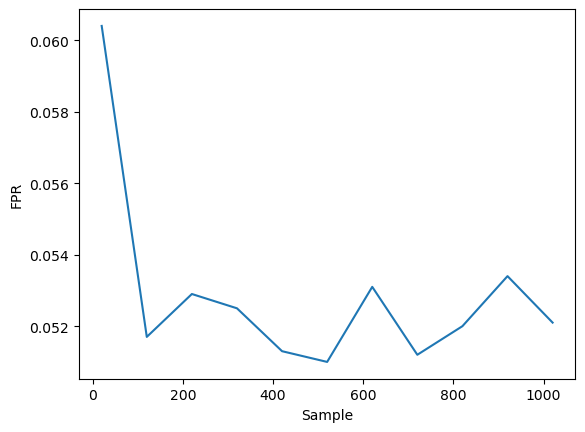

In [38]:
boot_fpr_results = pd.DataFrame({"Sample":list(range(20, 1100, 100)), "FPR":boot_fpr, "Method":"Bootstrap"})
sns.lineplot(data=boot_fpr_results, x="Sample", y="FPR")

Для маленьких выборок он высоковат, дальше становится лучше. Мб немного выше 0.05, но не сильно - можно списать на неточность симуляции. Думаю, дело решается увеличением числа итераций бутстрапа, а также изменением типа доверительного интервала - тут можно было бы использовать *стьюдентизованный бутстрап*, он же *бутстрап-t*, так как он должен работать лучше для маленьких размеров выборки. Здесь мы не будем его делать, но можно позаимствовать код [отсюда](http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/recitations/bootstrapping.html#3.-Studentized-Bootstrap).

Смотрим на неравные размеры выборок:

In [39]:
boot_fpr_uneq = []

for prop in tqdm(np.arange(0.05, 1.05, 0.1)):

    boot_fpr_uneq.append(boostrap_power_uneq(n=1000, test_prop=prop))

  0%|          | 0/10 [00:00<?, ?it/s]

<Axes: xlabel='Proportion', ylabel='FPR'>

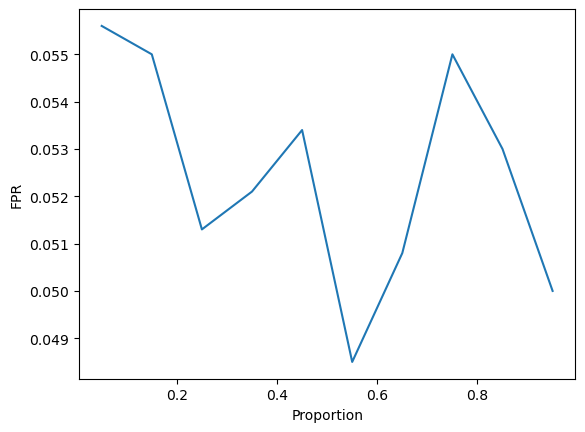

In [40]:
boot_fpr_uneq_results = pd.DataFrame({"Proportion":np.arange(0.05, 1.05, 0.1), "FPR":boot_fpr_uneq, "Method":"Bootstrap"})
sns.lineplot(data=boot_fpr_uneq_results, x="Proportion", y="FPR")

Сильновато гуляет, но думаю, это всё тот же эффект числа итераций.

Мощность:

In [41]:
boot_power = []

for sample_size in tqdm(range(20, 1100, 100)):

    boot_power.append(boostrap_power_uneq(n=sample_size, test_multiplier=1.1))

  0%|          | 0/11 [00:00<?, ?it/s]

<Axes: xlabel='Sample', ylabel='Power'>

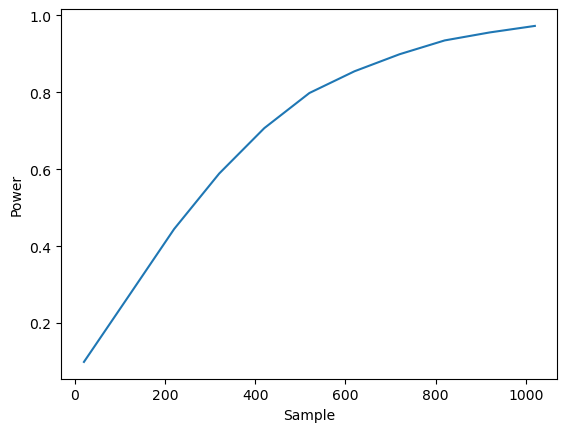

In [42]:
boot_power_results = pd.DataFrame({"Sample":list(range(20, 1100, 100)), "Power":boot_power, "Method":"Bootstrap"})
sns.lineplot(data=boot_power_results, x="Sample", y="Power")

Выглядит разумно. И для неравных размеров выборок:

In [43]:
boot_power_uneq = []

for prop in tqdm(np.arange(0.05, 1.05, 0.1)):

    boot_power_uneq.append(boostrap_power_uneq(n=1000, test_prop=prop, test_multiplier=1.1))

  0%|          | 0/10 [00:00<?, ?it/s]

<Axes: xlabel='Proportion', ylabel='Power'>

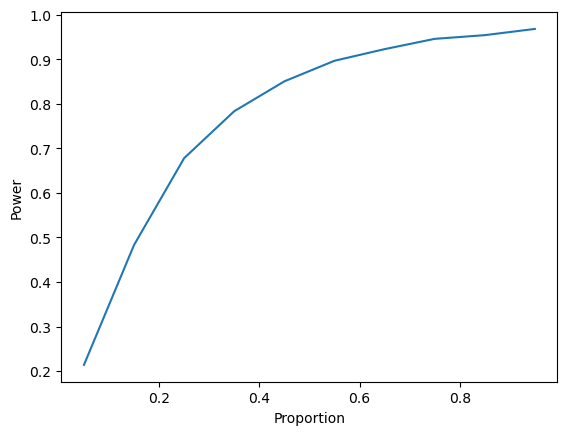

In [44]:
boot_power_uneq_results = pd.DataFrame({"Proportion":np.arange(0.05, 1.05, 0.1), "Power":boot_power_uneq, "Method":"Bootstrap"})
sns.lineplot(data=boot_power_uneq_results, x="Proportion", y="Power")

Тоже в целом ведёт себя как надо.

## Дельта-метод

А теперь давайте попробуем использовать метод, который тоже умеет оценивать дисперсию корректно, но при этом не требует симуляций! Как вы уже поняли по заголовку, называется он **дельта-методом**.

Что это такое и как это работает, к сожалению, пока что за пределами моего ущербного понимания этого мира. Для заинтересованных и не боящихся фразы "ряды Тейлора" я прикладываю вот этот [гайд](https://arxiv.org/pdf/1803.06336.pdf). В данном случае нам важно лишь то, что этот метод даёт нам формулу для оценки дисперсии отношения двух величин. Так как CTR - это отношение двух величин, то нам подходит!

Формула выглядит выглядит как довольно страшный многочлен:

$$\mathbb{V}(\mathcal{R}) = \mathbb{V}\left(\frac{X}{Y}\right) \approx \frac{\mathbb{V}(X)}{\mu^2_y} - \frac{2\times \mu_x \times cov(X, Y)}{\mu^3_y} + \frac{\mu^2_x \times \mathbb{V}(Y)}{\mu^4_y}$$

Здесь:

* $\mathcal{R}$ - отношение двух величин
* $\mathbb{V}()$ - дисперсия некой величины
* $X$ - величина в числителе (в данном случае лайки)
* $Y$ - величина в знаменателе (в данном случае просмотры)
* $\mu$ - среднее некой величины
* $cov$ - ковариация двух величин

Давайте попробуем немного проанализировать, как именно будет влиять каждый показатель на итоговое значение дисперсии и попробуем соотнести это с интуицией.

1. Дисперсия как лайков, так и просмотров находится в числителях соответствующих одночленов, причём оба одночлена имеют положительный знак. Значит, чем больше дисперсия каждого из этих показателей - тем больше дисперсия CTR. Звучит логично.
2. При этом дисперсия просмотров умножается на среднее значение лайков в 4 степени. Степень тут не так принципиальна; важнее то, что вклад дисперсии просмотров будет зависеть от величины среднего по лайкам - и наоборот. В целом можно предположить один вариант, как это может проявляться: если среднее значение лайков близко к нулю, то и CTR близок к нулю, какой бы там ни был разброс просмотров. Возможно, вы придумаете ещё.
3. Прежде чем мы посмотрим на вклад ковариации, стоит разобраться, что это такое вообще. Собственно, если вы знаете, что такое **корреляция**, то вы уже понимаете суть: корреляция - это стандартизованная ковариация. Т.е. ковариация - это **мера взаимосвязи двух переменных**, но не от -1 до 1, а в оригинальных единицах по обоим переменным. Поэтому для человеческой интерпретации этот показатель сложен, но он стоит за очень многими статистическими методами.

Будет полезно глянуть на реализацию расчёта ковариации в `numpy`:

In [21]:
np.cov(control.likes, control.views, ddof=1)

array([[10.52859259,  9.12613814],
       [ 9.12613814, 39.57004104]])

Функция даёт нам ковариационную матрицу, где:

* *Диагональ сверху вниз*: ковариация переменной с самой собой, она же **дисперсия**. То есть в левом углу у нас дисперсия лайков, в правом - дисперсия просмотров.
* *Диагональ снизу вверх*: ковариация переменной с другой переменной. Можно заметить, что по диагонали она одинаковая - ковариация лайков с просмотрами такая же, как и просмотров с лайками. Как и корреляция, ковариация не имеет направленности.

Соответственно, из этой матрицы можно извлекать и дисперсию, и ковариацию. Например, вот так можно извлечь число из первого ряда и второго столбца:

In [22]:
np.cov(control.likes, control.views, ddof=1)[0,1]

9.126138138138137

Но вернёмся к её вкладу. Ковариация также находится в числителе, но в отрицательном одночлене. Соответственно, чем выше ковариация - тем ниже дисперсия. Это тоже логично: если переменные хорошо коррелируют, то они меняются синхронно и фактически обладают общей дисперсией. А вот у независимых переменных числитель и знаменатель меняются как хотят, в результате общий разброс только растёт.

4. При этом она тоже умножается на среднее значение лайков - скорее всего, тут примерно те же приколы, что и с пунктом 2.
5. Со средними лайками интереснее - так как они сами являются многочленом $-2 \mu + \mu^2$. Давайте посмотрим на график этой функции, начиная с 0 и заканчивая 20:

<Axes: >

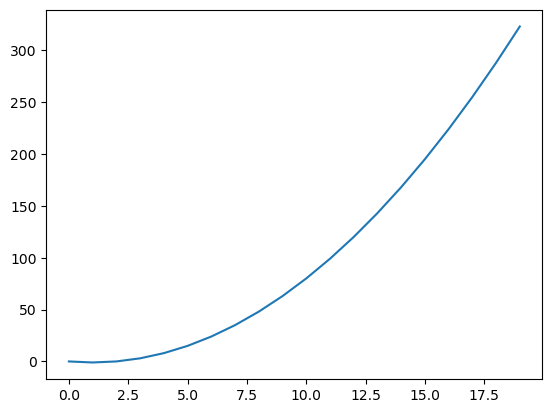

In [24]:
x = np.arange(0, 20)
y = -2*x + x**2

sns.lineplot(x=x, y=y)

В целом достаточно чёткий нелинейный тренд - чем больше среднее число лайков, тем выше дисперсия, причём вклад довольно быстро растёт. В целом неудивительно, учитывая, что чем больше лайков - тем более разнообразные значения CTR можно увидеть.

6. Ну и, наконец, среднее число просмотров - тоже многочлен, но позабористее:

$$\frac{1}{\mu^2_y} - \frac{1}{\mu^3_y} + \frac{1}{\mu^4_y} = \mu^{-2}_y - \mu^{-3}_y + \mu^{-4}_y$$

C:\Users\allom\AppData\Local\Temp\ipykernel_20792\3458549723.py:2: RuntimeWarning: divide by zero encountered in power
  y = x**(-2) - x**(-3) + x**(-4)
C:\Users\allom\AppData\Local\Temp\ipykernel_20792\3458549723.py:2: RuntimeWarning: invalid value encountered in subtract
  y = x**(-2) - x**(-3) + x**(-4)


<Axes: >

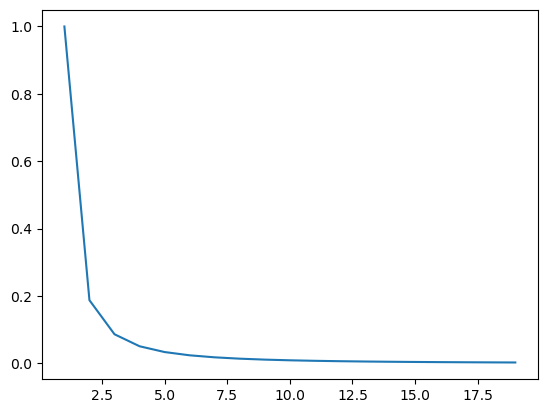

In [26]:
x = np.arange(0.0, 20.0)
y = x**(-2) - x**(-3) + x**(-4)

sns.lineplot(x=x, y=y)

Здесь, в свою очередь, видим резкое нелинейное падение - и оно приходит к нулю гораздо быстрее. То есть чем больше среднее число просмотров - тем ниже дисперсия, и при этом 1 просмотр не равноценен 1 лайку. 

Вот так вот хитро считается дисперсия для отношения двух величин. Нам осталось лишь подставить эту дисперсию вместо дисперсии, которую считает t-тест - и мы в шоколаде. Конечно, для таких фокусов нам фактически придётся написать расчёт t-теста самостоятельно, но это не такая сложная задача. Напоминаю, что t-статистика считается по этой формуле (обозначение выборочной дисперсии заменено на результат дельта-метода):

$$t = \frac{\mathcal{R}_A - \mathcal{R}_B}{\sqrt{\frac{\mathbb{V}(\mathcal{R}_A)}{n_A} + \frac{\mathbb{V}(\mathcal{R}_B)}{n_B}}}$$

Ну и чтобы окончательно приблизиться к стандартному t-тесту, для расчёта p-value мы будем использовать t-распределение, степени свободы которого мы будем считать по методу Уэлча (т.е. с поправкой на возможное неравенство дисперсий):

$$df = \frac{\left(\frac{\mathbb{V}(\mathcal{R}_A)}{n_A} + \frac{\mathbb{V}(\mathcal{R}_B)}{n_B}\right)^2}{\frac{(\mathbb{V}(\mathcal{R}_A) / n_A)^2}{n_A - 1}+\frac{(\mathbb{V}(\mathcal{R}_B) / n_B)^2}{n_B - 1}}$$

In [27]:
def delta_ttest(a, b):
    
    #размеры выборок
    n_a = a.shape[0]
    n_b = b.shape[0]
    
    #получаем CTR обеих групп
    ctr_a = a.likes.sum()/a.views.sum()
    ctr_b = b.likes.sum()/b.views.sum()

    
    #средние лайки
    mu_likes_a = a.likes.mean()
    mu_likes_b = b.likes.mean()

    #средние просмотры
    mu_views_a = a.views.mean()
    mu_views_b = b.views.mean()

    #дисперсии и ковариация лайков с просмотрами
    var_cov_a = np.cov(a.likes, a.views, ddof=1)
    var_cov_b = np.cov(b.likes, b.views, ddof=1)


    #считаем дисперсию CTR по кусочкам (и сразу делим на размеры выборок)
    comp_1_a = (var_cov_a[0,0] / (mu_views_a ** 2))
    comp_1_b = (var_cov_b[0,0] / (mu_views_b ** 2))

    comp_2_a = (2 * mu_likes_a * var_cov_a[0,1] / (mu_views_a ** 3))
    comp_2_b = (2 * mu_likes_b * var_cov_b[0,1] / (mu_views_b ** 3))

    comp_3_a = ((mu_likes_a ** 2) * var_cov_a[1,1] / (mu_views_a ** 4))
    comp_3_b = ((mu_likes_b ** 2) * var_cov_b[1,1] / (mu_views_b ** 4))

    var_ratio_a = (comp_1_a - comp_2_a + comp_3_a) / n_a
    var_ratio_b = (comp_1_b - comp_2_b + comp_3_b) / n_b


    #считаем сумму дисперсий
    denom = var_ratio_a + var_ratio_b 

    #считаем t-статистику
    t = (ctr_a - ctr_b) / (denom ** 0.5)

    #считаем степени свободы
    df = (denom ** 2) / (((var_ratio_a ** 2) / (n_a - 1)) + ((var_ratio_b ** 2) / (n_b - 1)))

    #считаем p-value
    pval = (1 - st.t.cdf(abs(t), df=df)) * 2

    return({"t":t, "p-value":pval})

Давайте посмотрим на результат:

In [29]:
delta_ttest(control, test)

{'t': -2.9295747132042784, 'p-value': 0.0034327866280881025}

Вроде выглядит не криминально. А скорость какая?

In [30]:
%timeit delta_ttest(control, test)

649 µs ± 61.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Ну прямо намного быстрее бутстрапа! Осталось лишь доказать, что его характеристики не хуже.

Но прежде чем мы это сделаем, проверю кое-что ещё. Я настолько рьяно ринулся писать t-тест с нуля, что совсем забыл про существование [этой функции](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind_from_stats.html). Она принимает на вход средние, стандартные отклонения, размеры выборок и ещё пару аргументов, после чего теоретически она должна выдать тот же результат, что и у меня.

А раз так, то давайте проверим это.

In [33]:
def delta_ttest_scipy(a, b):
    
    #размеры выборок
    n_a = a.shape[0]
    n_b = b.shape[0]
    
    #получаем CTR обеих групп
    ctr_a = a.likes.sum()/a.views.sum()
    ctr_b = b.likes.sum()/b.views.sum()

    
    #средние лайки
    mu_likes_a = a.likes.mean()
    mu_likes_b = b.likes.mean()

    #средние просмотры
    mu_views_a = a.views.mean()
    mu_views_b = b.views.mean()

    #дисперсии и ковариация лайков с просмотрами
    var_cov_a = np.cov(a.likes, a.views, ddof=1)
    var_cov_b = np.cov(b.likes, b.views, ddof=1)


    #считаем дисперсию CTR по кусочкам (и делаем из неё стандартное отклонение)
    comp_1_a = (var_cov_a[0,0] / (mu_views_a ** 2))
    comp_1_b = (var_cov_b[0,0] / (mu_views_b ** 2))

    comp_2_a = (2 * mu_likes_a * var_cov_a[0,1] / (mu_views_a ** 3))
    comp_2_b = (2 * mu_likes_b * var_cov_b[0,1] / (mu_views_b ** 3))

    comp_3_a = ((mu_likes_a ** 2) * var_cov_a[1,1] / (mu_views_a ** 4))
    comp_3_b = ((mu_likes_b ** 2) * var_cov_b[1,1] / (mu_views_b ** 4))

    std_ratio_a = (comp_1_a - comp_2_a + comp_3_a) **0.5
    std_ratio_b = (comp_1_b - comp_2_b + comp_3_b) **0.5

    #и тут применяем готовую функцию
    return(st.ttest_ind_from_stats(mean1=ctr_a, mean2=ctr_b, 
                                   std1=std_ratio_a, std2=std_ratio_b, 
                                   nobs1=n_a, nobs2=n_b, equal_var=False))

In [34]:
delta_ttest_scipy(control, test)

Ttest_indResult(statistic=-2.9295747132042784, pvalue=0.0034327866280881585)

К моему глубочайшему счастью, результат идентичен! А что по скорости?

In [36]:
%timeit delta_ttest_scipy(control, test)

627 µs ± 89.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Да будто бы не сильно и отличается с учётом разброса. Так что используем наш вариант - даром что ли писал это всё.

In [14]:
def delta_power_uneq(test_prop=1.0, n=1000, total_posts=50, a_views=10, b_views=10, a_likes=5, b_likes=20, alpha=0.05, num_iter=10000, test_multiplier=1.0):

    pvals = [] #сюда мы будем складывать результаты применения теста (значимо-незначимо)
    rng = np.random.default_rng() #генератор случайных чисел

    #повторяем процедуру несколько раз
    for _ in range(num_iter):

        control = generate_ctr_agg(rng, n=n, total_posts=total_posts, 
                                   a_views=a_views, b_views=b_views, 
                                   a_likes=a_likes, b_likes=b_likes) #данные контрольной группы
        test = generate_ctr_agg(rng, n=int(n*test_prop), total_posts=total_posts, 
                                a_views=a_views, b_views=b_views, 
                                a_likes=a_likes, b_likes=b_likes, multiplier=test_multiplier) #данные тестовой группы

        #используем дельта-вариант t-теста, извлекаем p-value
        #сравниваем его с alpha и результат сохраняем в список pvals
        pvals.append(delta_ttest(control, test)["p-value"] < alpha)

    #и считаем, какую долю от общего количества значеий составляют True
    #можно посчитать сумму True и поделить на длину списка
    #а можно просто посчитать среднее, это математически эквивалентно
    return(np.mean(pvals))

Смотрим FPR:

In [54]:
t_delta_fpr = []

for sample_size in tqdm(range(20, 1100, 20)):

    t_delta_fpr.append(delta_power_uneq(n=sample_size))

  0%|          | 0/54 [00:00<?, ?it/s]

<Axes: xlabel='Sample', ylabel='FPR'>

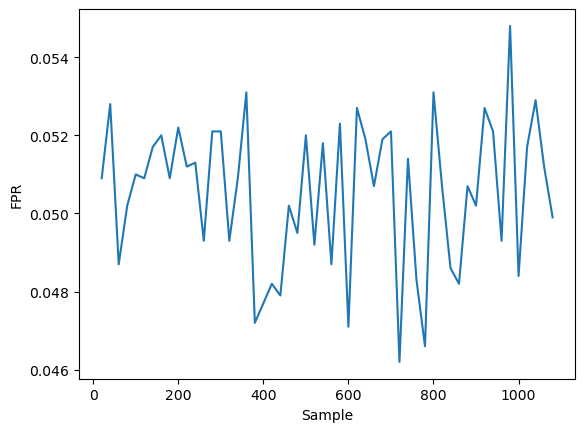

In [55]:
t_delta_fpr_results = pd.DataFrame({"Sample":list(range(20, 1100, 20)), "FPR":t_delta_fpr, "Method":"Delta"})
sns.lineplot(data=t_delta_fpr_results, x="Sample", y="FPR")

Выглядит вполне ок, ошибка I рода контролируется на нужном уровне!

А если выборки неравные?

In [56]:
t_delta_fpr_uneq = []

for prop in tqdm(np.arange(0.05, 1.05, 0.05)):

    t_delta_fpr_uneq.append(delta_power_uneq(n=1000, test_prop=prop))

  0%|          | 0/20 [00:00<?, ?it/s]

<Axes: xlabel='Proportion', ylabel='FPR'>

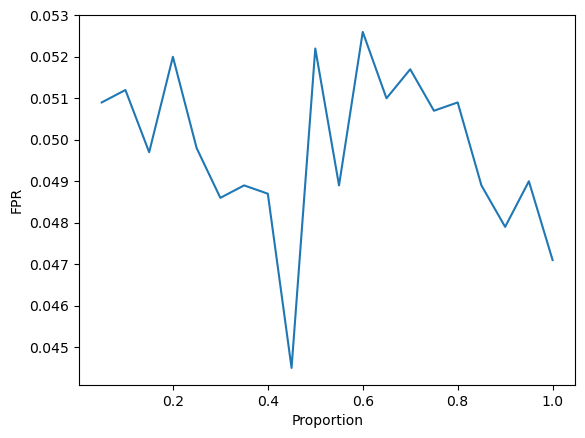

In [57]:
t_delta_fpr_uneq_results = pd.DataFrame({"Proportion":np.arange(0.05, 1.05, 0.05), "FPR":t_delta_fpr_uneq, "Method":"Delta"})
sns.lineplot(data=t_delta_fpr_uneq_results, x="Proportion", y="FPR")

Симуляции прям сильно разбросало, но в целом всё тоже в пределах нормы.

Мощность:

In [58]:
t_delta_power = []

for sample_size in tqdm(range(20, 1100, 20)):

    t_delta_power.append(delta_power_uneq(n=sample_size, test_multiplier=1.1))

  0%|          | 0/54 [00:00<?, ?it/s]

<Axes: xlabel='Sample', ylabel='Power'>

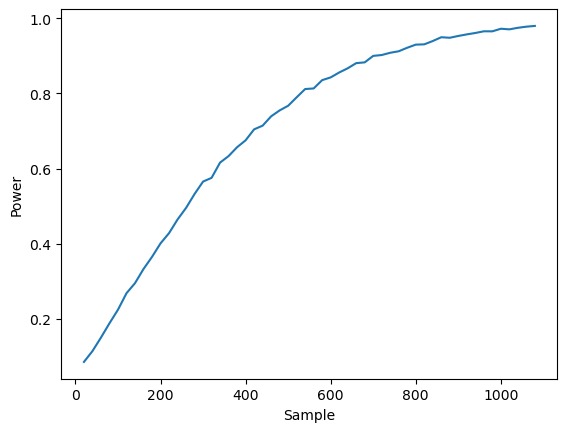

In [59]:
t_delta_power_results = pd.DataFrame({"Sample":list(range(20, 1100, 20)), "Power":t_delta_power, "Method":"Delta"})
sns.lineplot(data=t_delta_power_results, x="Sample", y="Power")

Тоже визуально как надо. И для неравных выборок:

In [60]:
t_delta_power_uneq = []

for prop in tqdm(np.arange(0.05, 1.05, 0.05)):

    t_delta_power_uneq.append(delta_power_uneq(n=1000, test_prop=prop, test_multiplier=1.1))

  0%|          | 0/20 [00:00<?, ?it/s]

<Axes: xlabel='Proportion', ylabel='Power'>

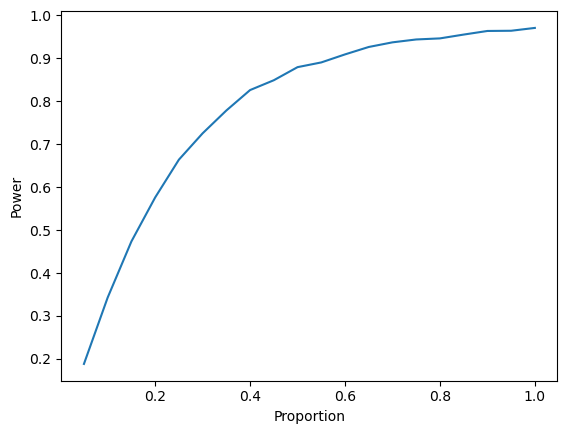

In [61]:
t_delta_power_uneq_results = pd.DataFrame({"Proportion":np.arange(0.05, 1.05, 0.05), "Power":t_delta_power_uneq, "Method":"Delta"})
sns.lineplot(data=t_delta_power_uneq_results, x="Proportion", y="Power")

Тест работает так, как от него и ожидают!

## Линеаризация

Наш последний метод отличается от предыдущих тем, что он не пытается напрямую скорректировать дисперсию. Вместо этого он идёт по тому же пути, что и расчёт пользовательского CTR - однако делает это таким образом, что лишается главных недостатков такого подхода.

Называется подход **линеаризацией**, и конкретно для CTR его придумали исследователи из Яндекса. Почитать статью, где они описывают процесс вывода и доказательства основных свойств метода, можно [тут](https://www.researchgate.net/publication/322969314_Consistent_Transformation_of_Ratio_Metrics_for_Efficient_Online_Controlled_Experiments). А мы с вами просто посмотрим на формулу - которая, в отличие от формулы дельта-метода, намного проще и фактически является функциональной формой линейной регрессии:

$$L = X - k*Y$$

Здесь:

* $X$ - метрика числителя (лайки)
* $Y$ - метрика знаменателя (просмотры)
* $L$ - линеаризованная метрика
* $k$ - значение показателя в контрольной группе (CTR контрольной группы)

Что нам значит для расчётов?

1. Вклад лайков и просмотров тот же, что и в обычный CTR - метрика растёт с увеличением числа лайков и падает с увеличением числа просмотров.
2. Однако все нелинейные взаимосвязи вычищены их расчётов. Абсолютный эффект от увеличения числа просмотров не зависит от текущего значения, а абсолютный эффект увеличения числа лайков не зависит от числа просмотров. Это две независимые по вкладу переменные.
3. Так как $k$ является показателем CTR, то вес просмотров ниже веса лайков - кроме случая с CTR=1, где веса равнозначны. Метрика отрицательна, если у конкретного пользователя CTR ниже, чем по контролю, и положительна, если он выше.

Самое важное следствие - теперь вклад индивидуального CTR будет напрямую зависеть от абсолютного количества просмотров и лайков! Рассмотрим случаи из прошлого ноутбука - пусть CTR в контроле будет равен 0.2:

In [37]:
print(f"1 лайк, 2 просмотра: {1 - 0.2*2}")
print(f"5 лайков, 10 просмотров: {5 - 0.2*10}")
print(f"500 лайков, 1000 просмотров: {500 - 0.2*1000}")

1 лайк, 2 просмотра: 0.6
5 лайков, 10 просмотров: 3.0
500 лайков, 1000 просмотров: 300.0


Вот теперь метрика понимает, какой пользователь вносит больший вклад, а какой меньший!

Давайте ещё проведём тот же тест, что и для пользовательских CTR. Насколько хорошо эта метрика коррелирует с CTR?

In [42]:
diff_ctr = []
diff_lin = []

#повторяем процедуру несколько раз
for _ in tqdm(range(10000)):

    control = generate_ctr_agg(rng, n=20) #данные контрольной группы
    test = generate_ctr_agg(rng, multiplier=1.1, n=20) #данные тестовой группы

    k = control.likes.sum() / control.views.sum() #ctr контрольной группы
    
    diff_ctr.append(k - (test.likes.sum() / test.views.sum())) 
    diff_lin.append(np.mean(control.likes - k*control.views) - np.mean(test.likes - k*test.views))

  0%|          | 0/10000 [00:00<?, ?it/s]

<Axes: >

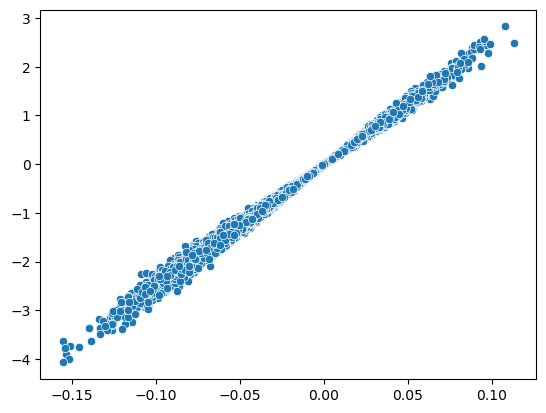

In [43]:
sns.scatterplot(x=diff_ctr, y=diff_lin)

Не идеально, но значения лежат гораздо ближе к прямой! Есть ли случаи отсутствия сонаправленности?

In [44]:
print(f"Доля случаев, когда CTR вырос, а линеаризованный CTR упал: {np.sum((np.array(diff_ctr) > 0) & (np.array(diff_lin) < 0)) / 10000}")
print(f"Доля случаев, когда CTR упал, а линеаризованный CTR вырос: {np.sum((np.array(diff_ctr) < 0) & (np.array(diff_lin) > 0)) / 10000}")

Доля случаев, когда CTR вырос, а линеаризованный CTR упал: 0.0
Доля случаев, когда CTR упал, а линеаризованный CTR вырос: 0.0


Таких нет! То есть у нас как минимум есть гарантия, что метрика изменится в ту же сторону, в которую мы ждём.

А если увеличить размер выборки?

In [45]:
diff_ctr = []
diff_lin = []

#повторяем процедуру несколько раз
for _ in tqdm(range(10000)):

    control = generate_ctr_agg(rng, n=1000) #данные контрольной группы
    test = generate_ctr_agg(rng, multiplier=1.1, n=1000) #данные тестовой группы

    k = control.likes.sum() / control.views.sum() #ctr контрольной группы
    
    diff_ctr.append(k - (test.likes.sum() / test.views.sum())) 
    diff_lin.append(np.mean(control.likes - k*control.views) - np.mean(test.likes - k*test.views))

  0%|          | 0/10000 [00:00<?, ?it/s]

<Axes: >

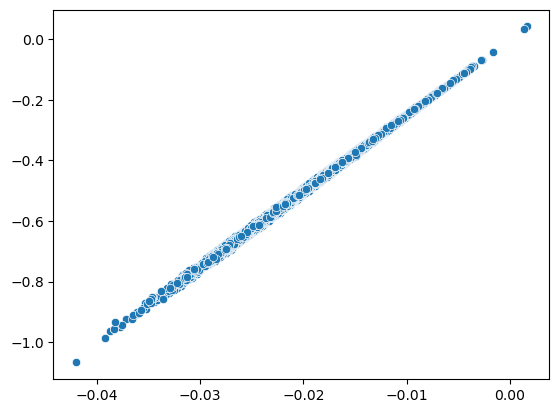

In [46]:
sns.scatterplot(x=diff_ctr, y=diff_lin)

Вообще почти идеальная корреляция! Значит, чем больше выборка - тем больше вы можем доверять, что линеаризованный CTR изменится в ту же сторону, что и обычный. 

Ещё можно отметить, что так как это фактически преобразование метрики по юзерам, то мы не ограничены t-тестом и может использовать любые другие методы - хоть Манна-Уитни. Ну и будут работать такие стратегии увеличения чувствительности как [стратификация](https://habr.com/ru/companies/X5Tech/articles/596279/) и [CUPED](https://habr.com/ru/companies/yandex/articles/497804/). Сплошные плюсы!

Сделаем функцию для t-теста на линеаризованном CTR:

In [48]:
def lin_ttest(control, test):

    #CTR в контрольной группе
    ctr_control = control.likes.sum()/control.views.sum()

    #линеаризуем лайки
    lin_control = control.likes - (ctr_control * control.views)
    lin_test = test.likes - (ctr_control * test.views)

    #сравниваем t-тестом и возвращаем
    return(st.ttest_ind(lin_control, lin_test, equal_var=False))

Посмотрим на результаты:

In [49]:
control = generate_ctr_agg(rng=np.random.default_rng(2112))
test = generate_ctr_agg(rng=np.random.default_rng(2113), multiplier=1.1)

lin_ttest(control, test)

TtestResult(statistic=-2.9416500972319377, pvalue=0.0033023303751693114, df=1993.8511875666293)

Неплохо! Более того, t-статистика самую чуточку выше, чем у дельта-метода - то есть это ещё и более чувствительный метод.

Сделаем функцию для симуляций:

In [50]:
def lin_power_uneq(test_prop=1.0, n=1000, total_posts=50, a_views=10, b_views=10, a_likes=5, b_likes=20, alpha=0.05, num_iter=10000, test_multiplier=1.0):

    pvals = [] #сюда мы будем складывать результаты применения теста (значимо-незначимо)
    rng = np.random.default_rng() #генератор случайных чисел

    #повторяем процедуру несколько раз
    for _ in range(num_iter):

        control = generate_ctr_agg(rng, n=n, total_posts=total_posts, 
                                   a_views=a_views, b_views=b_views, 
                                   a_likes=a_likes, b_likes=b_likes) #данные контрольной группы
        test = generate_ctr_agg(rng, n=int(n*test_prop), total_posts=total_posts, 
                                a_views=a_views, b_views=b_views, 
                                a_likes=a_likes, b_likes=b_likes, multiplier=test_multiplier) #данные тестовой группы

        #используем линеаризованный t-тест, извлекаем p-value
        #сравниваем его с alpha и результат сохраняем в список pvals
        pvals.append(lin_ttest(control, test).pvalue < alpha)

    #и считаем, какую долю от общего количества значений составляют True
    #можно посчитать сумму True и поделить на длину списка
    #а можно просто посчитать среднее, это математически эквивалентно
    return(np.mean(pvals))

Поехали. FPR:

In [66]:
t_lin_fpr = []

for sample_size in tqdm(range(20, 1100, 20)):

    t_lin_fpr.append(lin_power_uneq(n=sample_size))

  0%|          | 0/54 [00:00<?, ?it/s]

<Axes: xlabel='Sample', ylabel='FPR'>

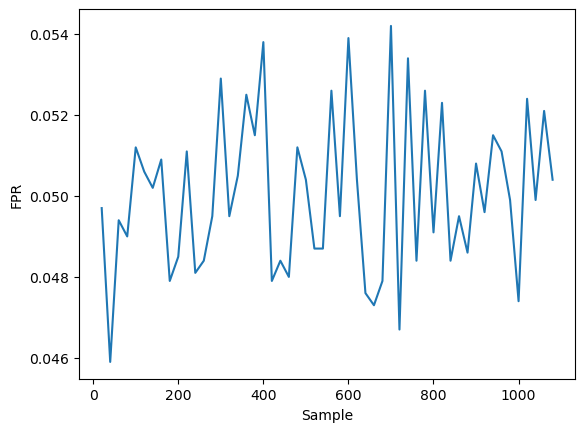

In [67]:
t_lin_fpr_results = pd.DataFrame({"Sample":list(range(20, 1100, 20)), "FPR":t_lin_fpr, "Method":"Linearization"})
sns.lineplot(data=t_lin_fpr_results, x="Sample", y="FPR")

Выглядит ок! Для неравных выборок:

In [68]:
t_lin_fpr_uneq = []

for prop in tqdm(np.arange(0.05, 1.05, 0.05)):

    t_lin_fpr_uneq.append(lin_power_uneq(n=1000, test_prop=prop))

  0%|          | 0/20 [00:00<?, ?it/s]

<Axes: xlabel='Proportion', ylabel='FPR'>

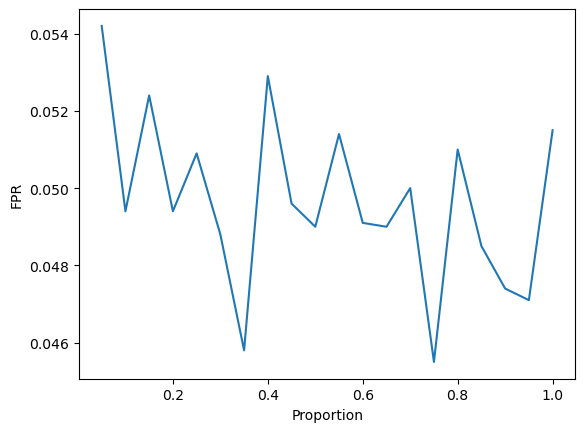

In [69]:
t_lin_fpr_uneq_results = pd.DataFrame({"Proportion":np.arange(0.05, 1.05, 0.05), "FPR":t_lin_fpr_uneq, "Method":"Linearization"})
sns.lineplot(data=t_lin_fpr_uneq_results, x="Proportion", y="FPR")

Мб на малых размерах чуть завышено, но всё ещё выглядит в пределах нормы.

Мощность:

In [70]:
t_lin_power = []

for sample_size in tqdm(range(20, 1100, 20)):

    t_lin_power.append(lin_power_uneq(n=sample_size, test_multiplier=1.1))

  0%|          | 0/54 [00:00<?, ?it/s]

<Axes: xlabel='Sample', ylabel='Power'>

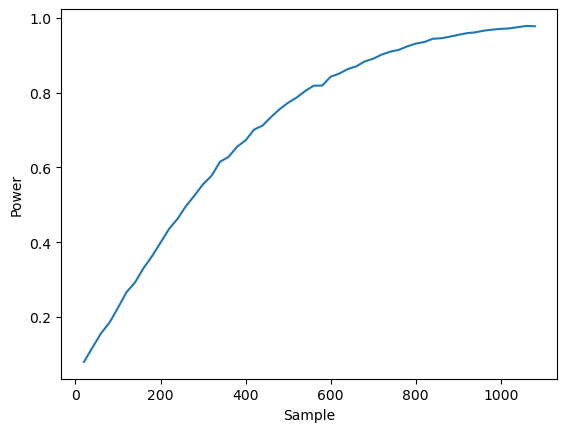

In [71]:
t_lin_power_results = pd.DataFrame({"Sample":list(range(20, 1100, 20)), "Power":t_lin_power, "Method":"Linearization"})
sns.lineplot(data=t_lin_power_results, x="Sample", y="Power")

Тоже никаких особенностей. И для неравных выборок:

In [72]:
t_lin_power_uneq = []

for prop in tqdm(np.arange(0.05, 1.05, 0.05)):

    t_lin_power_uneq.append(lin_power_uneq(n=1000, test_prop=prop, test_multiplier=1.1))

  0%|          | 0/20 [00:00<?, ?it/s]

<Axes: xlabel='Proportion', ylabel='Power'>

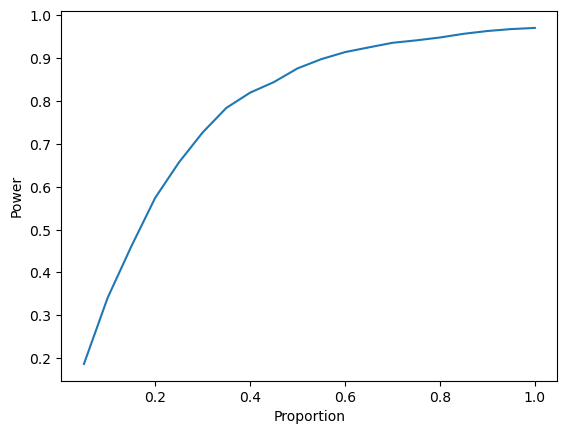

In [73]:
t_lin_power_uneq_results = pd.DataFrame({"Proportion":np.arange(0.05, 1.05, 0.05), "Power":t_lin_power_uneq, "Method":"Linearization"})
sns.lineplot(data=t_lin_power_uneq_results, x="Proportion", y="Power")

Никаких внешних особенностей. А теперь давайте сравнивать три наших метода в одних координатах.

## Сравниваем методы

Начн1м с мощности:

<Axes: xlabel='Sample', ylabel='Power'>

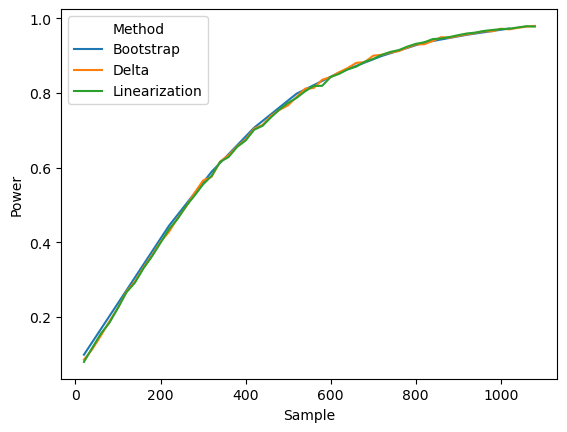

In [74]:
all_power = pd.concat([boot_power_results, t_delta_power_results, t_lin_power_results])
sns.lineplot(data=all_power, x="Sample", y="Power", hue="Method")

Все три кривые практически идеально совпадают! У бутстрапа мб мощность чуть-чуть повыше на малых размерах выборки, но может быть следствием его большей либеральности.

Неравные выборки:

<Axes: xlabel='Proportion', ylabel='Power'>

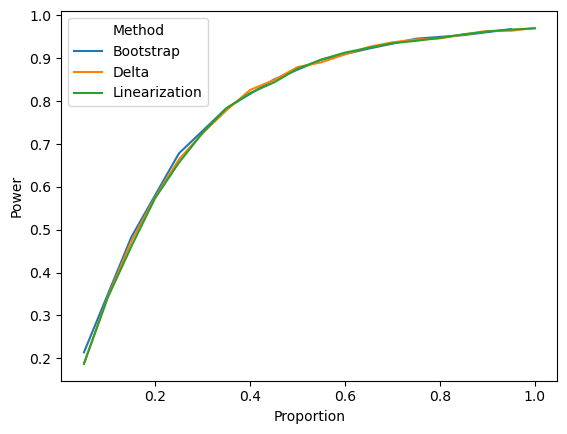

In [75]:
all_power_uneq = pd.concat([boot_power_uneq_results, t_delta_power_uneq_results, t_lin_power_uneq_results])
sns.lineplot(data=all_power_uneq, x="Proportion", y="Power", hue="Method")

В целом те же паттерны.

FPR:

<Axes: xlabel='Sample', ylabel='FPR'>

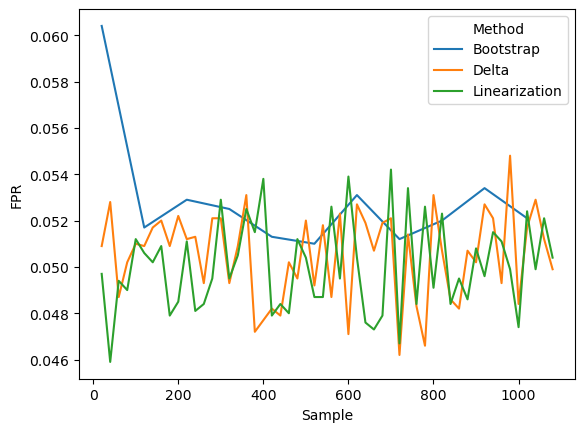

In [76]:
all_fpr = pd.concat([boot_fpr_results, t_delta_fpr_results, t_lin_fpr_results])
sns.lineplot(data=all_fpr, x="Sample", y="FPR", hue="Method")

Видим, что на малых выборках бутстрап завышает ошибку I рода, но в остальном всё достаточно однородно.

Неравные выборки:

<Axes: xlabel='Proportion', ylabel='FPR'>

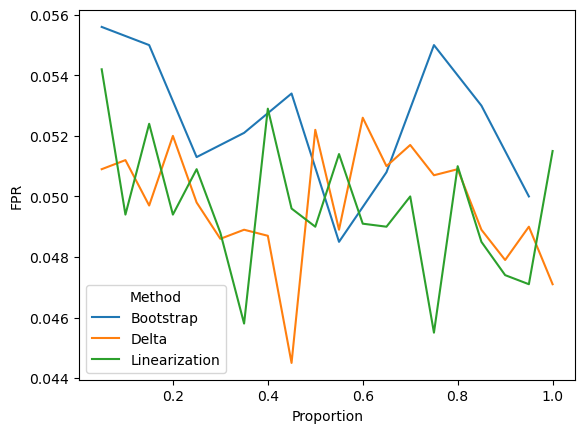

In [77]:
all_fpr_uneq = pd.concat([boot_fpr_uneq_results, t_delta_fpr_uneq_results, t_lin_fpr_uneq_results])
sns.lineplot(data=all_fpr_uneq, x="Proportion", y="FPR", hue="Method")

Тут больше разброса, но я бы сказал, что всё примерно в одних пределах.

Сохраним на будущее эти замеры:

In [78]:
all_power.to_csv("industrial_power.csv", index=False)
all_power_uneq.to_csv("industrial_power_uneq.csv", index=False)
all_fpr.to_csv("industrial_fpr.csv", index=False)
all_fpr_uneq.to_csv("industrial_fpr_uneq.csv", index=False)

В целом и общем все три метода хороши на больших выборках, но для CTR я бы отдал предпочтение линеаризации. Слишком уж много возможностей она даёт задёшево.